# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from os.path import exists
from sklearn.cluster import KMeans

if not exists('mnist.csv'):
    X, y = fetch_openml(name="mnist_784", version=1,
                        return_X_y=True, as_frame=False)
    pd.DataFrame(X).join(pd.DataFrame({'Label': y})).to_csv('mnist.csv', index=False)

df = pd.read_csv('mnist.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


b) Plot the singular value plot for a single example of the 0 digit (5 points)

Text(0, 0.5, 'Singular Values')

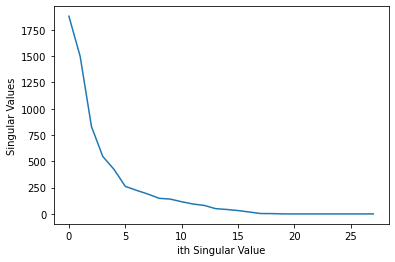

In [2]:
zero = df[df['Label'] == 0].sample()
zero = zero.iloc[:, :784].values.reshape(28, 28)

u, s, v = np.linalg.svd(zero)
plt.plot(s)
plt.xlabel('ith Singular Value')
plt.ylabel('Singular Values')

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

Text(0.5, 0.98, 'Original vs Dim Reduced')

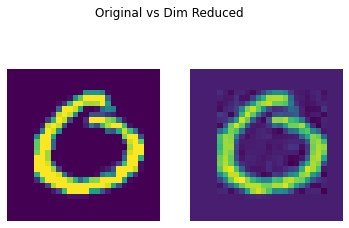

In [3]:
rank = 6
compressed_zero = u[:, :rank] @ np.diag(s[:rank]) @ v[:rank]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(zero)
axes[0].set_axis_off()
axes[1].imshow(compressed_zero)
axes[1].set_axis_off()
fig.suptitle('Original vs Dim Reduced')

d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

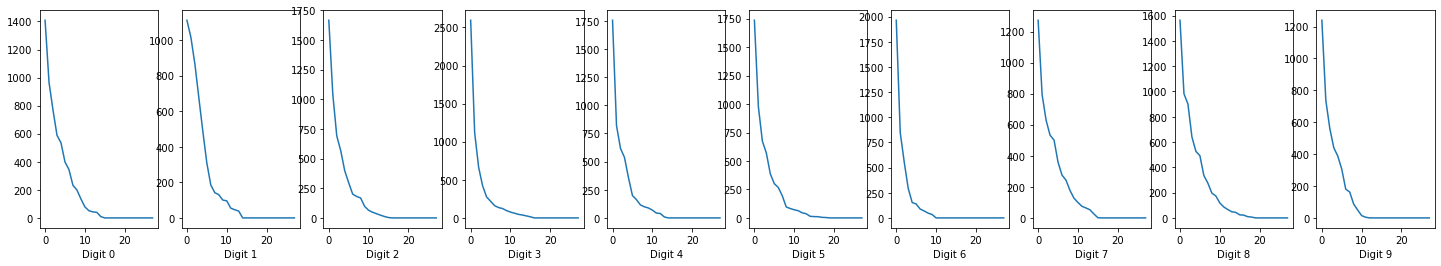

In [4]:
def compressImage(image, rank=28):
    u, s, v = np.linalg.svd(image.reshape(28, 28))
    newImage = u[:, :(rank + 1)] @ np.diag(s[:(rank + 1)]) @ v[:(rank + 1)]
    return newImage.reshape(784)

def compressData(data, rank=28):
    compressedData = []
    for row in data:
        compressedData.append(compressImage(row, rank))
    return np.array(compressedData)

images = []
for i in range(10):
    images.append(df[df['Label'] == i].sample())

fig, axes = plt.subplots(1, 10)
for ax, digit, img in zip(axes, range(10), images):
    ax.set_xlabel(xlabel='Digit ' + str(digit))
    _, s, _ = np.linalg.svd(img.iloc[:, :784].values.reshape(28, 28))
    ax.plot(s)

fig.set_figwidth(25)

In [5]:
if not exists('compressed_mnist.csv'):
    pd.DataFrame(compressData(df.iloc[:, :784].values, 9)).join(df['Label']).to_csv('compressed_mnist.csv', index=False)

df_compressed = pd.read_csv('compressed_mnist.csv')

One would probably look at the singular values on a graph, for each digit, and pick the number of singular values to keep, in order to have a relatively good reconstruction of each digit thus not losing too much information.
I chose to compress to rank 9.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

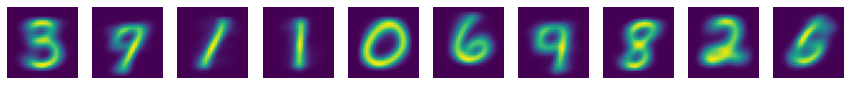

In [6]:
kmeans_compressed = KMeans(n_clusters=10).fit(df_compressed.iloc[:, :784].values)

fig, axes = plt.subplots(1, 10)
for ax, digit in zip(axes, kmeans_compressed.cluster_centers_):
  ax.set_axis_off()
  img = digit.reshape(28, 28)
  ax.imshow(img)

fig.set_figwidth(15)
fig.set_figheight(15)

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

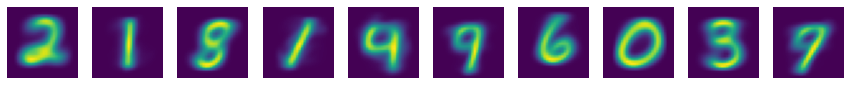

In [7]:
kmeans = KMeans(n_clusters=10).fit(df.iloc[:, :784].values)

fig, axes = plt.subplots(1, 10)
for ax, digit in zip(axes, kmeans.cluster_centers_):
  ax.set_axis_off()
  img = digit.reshape(28, 28)
  ax.imshow(img)

fig.set_figwidth(15)
fig.set_figheight(15)

The kmeans seems to be performing similarly across the dim reduced and the original datasets. They seem to be both missing definitive images of digits 4 and 7.

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [10]:
def disagreement_dist(P_labels, C_labels):
    """
    Calculate the disagreement distance between `P_Labels` and `C_Labels`
    """
    ans = 0
    num_of_classes = len(set(P_labels))
    df_temp = pd.DataFrame({'Label': P_labels}).join(
        pd.DataFrame({'Predicted Label': C_labels}))
    
    for i in range(num_of_classes):
        temp = df_temp[df_temp['Label'] == i]
        s1 = temp['Predicted Label'].value_counts()
        nums = 0
        sum = s1.sum()
        for val in s1.values:
            nums += val
            ans += val * (sum - nums)

        temp = df_temp[df_temp['Predicted Label'] == i]
        s1 = temp['Label'].value_counts()
        nums = 0
        sum = s1.sum()
        for val in s1.values:
            nums += val
            ans += val * (sum - nums)
        
    return ans

In [9]:
compressed_dist = disagreement_dist(df_compressed['Label'].values, kmeans_compressed.labels_)
original_dist = disagreement_dist(df['Label'].values, kmeans.labels_)

print('The disagreement distance of the compressed image clustering is: {}'.format(compressed_dist))
print('The disagreement distance of the original image clustering is: {}'.format(original_dist))

The disagreement distance of the compressed image clustering is: 289621731
The disagreement distance of the original image clustering is: 285114179


The distances seem to be similar. After running it a few times with different clusterings, they produce similar results. (They switch on being the better one)

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [11]:
df_compressed = pd.DataFrame(compressData(df.iloc[:, :784].values, rank=10)).join(
    df["Label"]
)

diff_matrix = df.iloc[:, :784].values - df_compressed.iloc[:, :784].values

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

In [12]:
def calcDistance(diff):
    distances = []
    for row in diff:
        distances.append(np.linalg.norm(row))
    return pd.Series(distances)

df['Distance'] = calcDistance(diff_matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,Label,Distance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,110.002727
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,111.266538
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14.291287
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43.902646
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,89.049266


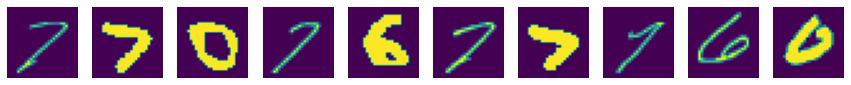

In [13]:
df = df.sort_values(by=['Distance'], ascending=False)

fig, axes = plt.subplots(1, 10)
for ax, digit in zip(axes, df.iloc[:, :784].values):
  ax.set_axis_off()
  img = digit.reshape(28, 28)
  ax.imshow(img)

fig.set_figwidth(15)
fig.set_figheight(15)

These images seem to be anomalous because they are very deformed compared to the other images/kmeans centres. They are either too thin or too thick and it is even difficult to understand which digit is which.

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import sys
from os.path import exists


categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.guns']
news_data = fetch_20newsgroups(subset='train', categories=categories)


[nltk_data] Downloading package punkt to /Users/ivan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [15]:
stemmer = SnowballStemmer('english', ignore_stopwords=True)
stemmed_articles = [' '.join(stemmer.stem(word) for sent in sent_tokenize(article) for word in word_tokenize(sent)) for article in news_data['data']]

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [16]:
vectoriser = TfidfVectorizer(stop_words='english', min_df=0.01, max_df=0.8)

vectorised_data = vectoriser.fit_transform(stemmed_articles)
centred_data = vectorised_data - np.mean(vectorised_data, axis=0)

In [17]:
if not exists('vectorised_data.csv'):
    pd.DataFrame(centred_data).join(pd.DataFrame({'Target' : news_data['target']})).to_csv('vectorised_data.csv', index=False)

The intuition behind my reasoning is that the very low and very high frequency words will be discarded since they are most likely just prepositions or definite or indefinite articles, etc. But the valuable words, that define a certain topic, will be kept in the model.

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

 24

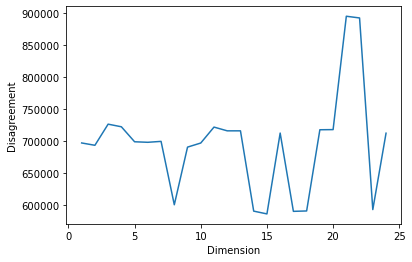

In [18]:
u, s, v = np.linalg.svd(centred_data)
disagreement_distance = []
for k in range(1,25):
    dim_reduced_dataset = u[:, :k] @ np.diag(s[:k]) @ v[:k]
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))
    sys.stdout.write('\r {}'.format(k))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

It appears that there are some dimensions where there is a lot of information regarding the embedding of words. So when we reduce to that dimension we gain a decrease in disagreement distance and increase in performance.